<a href="https://colab.research.google.com/github/sayantan16/Deep-Learning-Tensorflow/blob/main/05_transfer_learning_tensorflow_Part_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2 - Fine Tuning

## Imports and Functions

In [133]:
# Import helper functions
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np

--2023-08-24 04:23:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-24 04:23:28 (80.6 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [134]:
# Functions

! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-24 04:23:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.5’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-24 04:23:28 (83.2 MB/s) - ‘helper_functions.py.5’ saved [10246/10246]



Before and After Loss Curves (Compare History Function)

In [135]:
# Function to plot loss curves of one series of running a model history with another model's history

def compare_history(original_history, new_history, initial_steps=5):
  """
  Compares two Tensorflow History Objects
  """

  # Get original_history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["accuracy"]
  total_val_loss = val_loss + new_history.history["loss"]

  # Make plots accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Validation accuracy")
  plt.plot([initial_steps-1, initial_steps-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Validation loss")
  plt.plot([initial_steps-1, initial_steps-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

Create Base Model Function

In [136]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

## Getting Data

Using `tf.keras.applications` to use pre trained models and using in our own solution (recognising images of food)

In [137]:
# Get 10% of training data of food 101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-08-24 04:23:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  21.3MB/s    in 8.7s    

2023-08-24 04:23:41 (18.5 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [138]:
# Check the number of images and subdirectories in the database

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [139]:
# Create training and test directory path

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [140]:
# Creating training and test data sets

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [141]:
# Check out class names of the dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [142]:
# Example of the batch dataset which the training data has become

for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[118.79082    103.79082    107.505104  ]
   [124.688774   111.61735    103.974495  ]
   [117.79082    108.5         95.87245   ]
   ...
   [128.52036    135.29079    145.36731   ]
   [124.4337     133.90822    144.19392   ]
   [125.15808    138.15808    147.15808   ]]

  [[119.52551    104.52551    108.2398    ]
   [116.85204    103.78062     98.13776   ]
   [117.64285    107.64285     97.72959   ]
   ...
   [124.14285    133.         141.6429    ]
   [123.28573    136.08675    144.15308   ]
   [122.80608    136.76016    145.76016   ]]

  [[121.         106.64286    109.71428   ]
   [120.158165   109.158165   105.30102   ]
   [118.87755    108.02041    100.30612   ]
   ...
   [124.59688    135.59688    141.50505   ]
   [122.92856    135.92856    143.49998   ]
   [122.714355   137.28578    144.50008   ]]

  ...

  [[123.87238    123.22952     91.1581    ]
   [131.71431    130.71431    102.57145   ]
   [128.8571     127.025475   101.520355  ]
   ...
   [ 97.63788     78.637

# Building a model using TF.Keras.Applications

Feature Extraction Model with Keras Functional API

1. Model 0 - Base model with 10% training data and feature extraction.
2. Model 1 - Base model with 1% training data with data augmentation.
3. Model 2 - Base model with 10% training data with data augmentation and feature extraction.
4. Model 3 - Base model with fine-tuning transfer learning on 10% of the training data with data data augmentation.
5. Model 4 - Using model 3 but with 100% of the training data.

Note: On all the models, the test_data set remains the same.

## 1. Model 0 - Base model with 10% training data and feature extraction.

In [143]:
# 1. Create base model using tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # top layer has 1000 labels but we are working with only 10

# 2. Freeze the base model (underlying pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, we need to normalize input (not needed in efficient net)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate the most important info and reduce the no of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                         epochs=5,
                         steps_per_epoch=len(train_data_10_percent),
                         validation_data=test_data,
                         validation_steps=int(0.25 * len(test_data)),
                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="10_percent_feature_extraction")])

Shape after passing through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230824-042347
Epoch 1/5
24/24 [==============================] - 14s 275ms/step - loss: 1.8522 - accuracy: 0.4387 - val_loss: 1.3067 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.0826 - accuracy: 0.7667 - val_loss: 0.8628 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 5s 182ms/step - loss: 0.7806 - accuracy: 0.8293 - val_loss: 0.6731 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 4s 150ms/step - loss: 0.6322 - accuracy: 0.8613 - val_loss: 0.6011 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 6s 216ms/step - loss: 0.5454 - accuracy: 0.8827 - val_loss: 0.5265 - val_accuracy: 0.8536


In [144]:
# Evaluate on full test dataset

model_0.evaluate(test_data)

79/79 [==============================] - 8s 89ms/step - loss: 0.5527 - accuracy: 0.8616


[0.5527009963989258, 0.8615999817848206]

In [145]:
# Check the layers in the base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_15
1 rescaling_23
2 normalization_14
3 rescaling_24
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_acti

In [146]:
# Summary of the base model

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_23 (Rescaling)       (None, None, None,   0           ['input_15[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_14 (Normalizatio  (None, None, None,   7          ['rescaling_23[0][0]']           
 n)                             3)                                                   

In [147]:
# Summary of the whole model

model_0.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


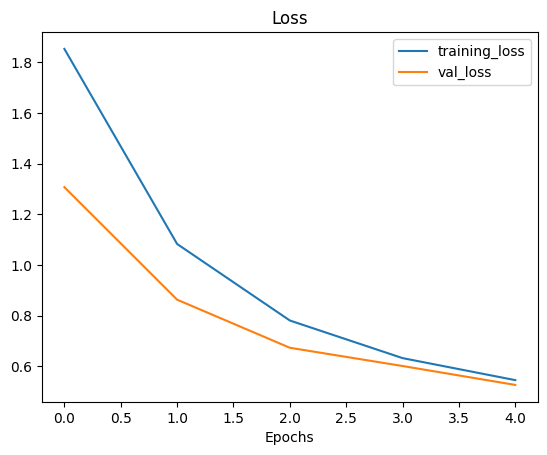

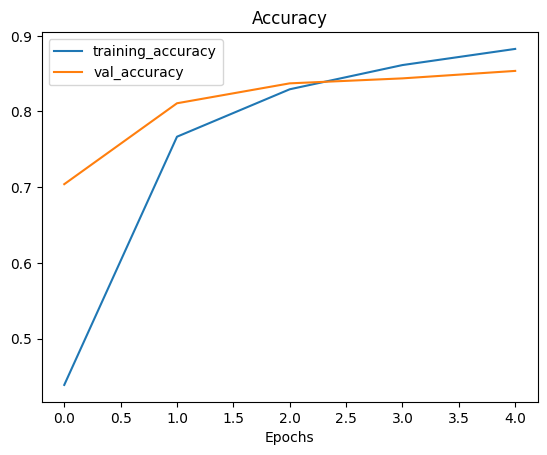

In [148]:
# Models training curves

plot_loss_curves(history=history_0)

### Getting a feature vector from a trained model

In [149]:
# Define the input shape

input_shape = (2, 3, 4, 3)

# create a random tensor

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the tensor through the global average pooling 2d layer

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Pass the tensor through the global max pooling 2d layer

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of average pooled tensor: {global_average_pooled_tensor.shape}")
print(f"Shape of max pooled tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 3.27468514e-01 -8.42625797e-01  3.19433689e-01]
   [-1.40755188e+00 -2.38805985e+00 -1.03924787e+00]
   [-5.57323217e-01  5.39707005e-01  1.69943225e+00]
   [ 2.88936555e-01 -1.50661159e+00 -2.64547408e-01]]

  [[-5.97224057e-01 -1.91711318e+00 -6.20441437e-01]
   [ 8.50402296e-01 -4.06047940e-01 -3.02584124e+00]
   [ 9.05846417e-01  2.98559874e-01 -2.25615546e-01]
   [-7.61644304e-01 -1.89171410e+00 -9.38471258e-01]]

  [[ 7.78522134e-01 -4.73388970e-01  9.77726936e-01]
   [ 2.46944040e-01  2.05737472e-01 -5.25623322e-01]
   [ 3.24100167e-01  2.54540909e-02 -1.06384970e-01]
   [-6.36947513e-01  1.16031218e+00  2.50735909e-01]]]


 [[[-4.17285025e-01  4.01257813e-01 -1.41454434e+00]
   [-5.93185723e-01 -1.66172135e+00  3.35671932e-01]
   [ 1.08156286e-01  2.34796822e-01 -5.66687644e-01]
   [-3.58198434e-01  8.86986136e-01  5.27447641e-01]]

  [[ 7.04022467e-01 -3.34212482e-01  2.16396436e-01]
   [-9.74854469e-01 -2.07576811e-01 -3.64772938e-02]
   [-1.3353444

In [150]:
# Replicating the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.01987256, -0.59964925, -0.29157034],
       [-0.22964358,  0.08201998, -0.16998672]], dtype=float32)>

## 2. Model 1 - Base model with 1% training data with data augmentation.

In [151]:
# Download the dataset

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-24 04:24:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  23.1MB/s    in 6.6s    

2023-08-24 04:24:47 (19.2 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [152]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [153]:
# Number of images

walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [154]:
# set the datasets

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [155]:
# Adding data augmentation in the model

# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # Needed for ResNet50V2, not needed for efficientnet
], name="data_augmentation")

In [156]:
# Creating Model 1

# Setup input shape and base model and freeze base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after augmentation and dont train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a Dense layer on the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make the model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230824-042452
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3481 - accuracy: 0.0857 - val_loss: 2.2359 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1111 - accuracy: 0.2571 - val_loss: 2.1034 - val_accuracy: 0.2599
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8869 - accuracy: 0.4857 - val_loss: 1.9643 - val_accuracy: 0.3602
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.7107 - accuracy: 0.6000 - val_loss: 1.8568 - val_accuracy: 0.4276
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5328 - accuracy: 0.7571 - val_loss: 1.7474 - val_accuracy: 0.4967


In [157]:
model_1.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [158]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 1.7556 - accuracy: 0.4880


[1.7556082010269165, 0.4880000054836273]

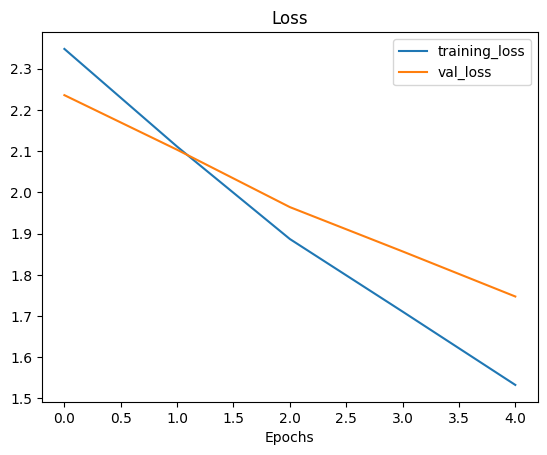

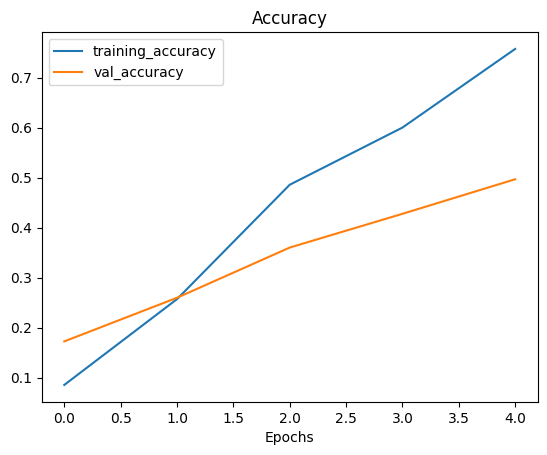

In [159]:
plot_loss_curves(history=history_1)

### Visualizing the data augmentation using random image

Target Directory: 10_food_classes_1_percent/train/chicken_curry
Random Image Path: 10_food_classes_1_percent/train/chicken_curry/3909335.jpg


(-0.5, 501.5, 542.5, -0.5)

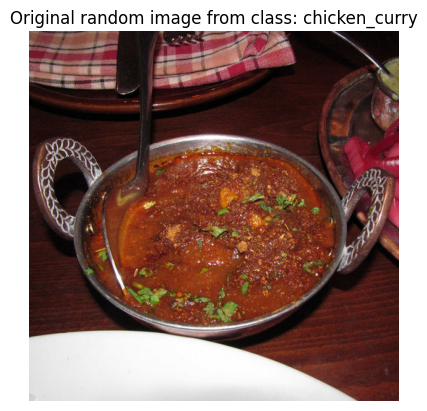

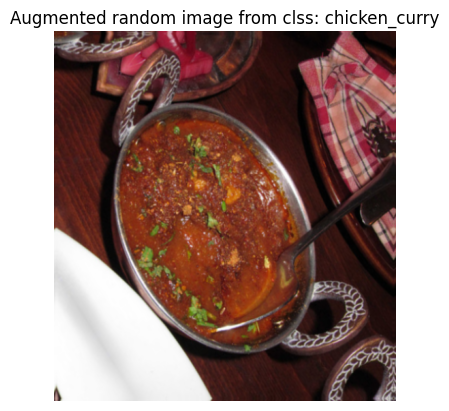

In [160]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(f"Target Directory: {target_dir}")

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(f"Random Image Path: {random_image_path}")

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Plot the augmented random image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from clss: {target_class}")
plt.axis(False)

## Model 2 - Base model with 10% training data with data augmentation and feature extraction.

In [161]:
# Get 10% data

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent.zip)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [162]:
# Set the data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [163]:
# Create model 2 with data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # only if using the resnet model
], name = "data_augmentation")

# Setup the input shape
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating a ModelCheckpoint Callback

In [164]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a model checkpoint callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [165]:
# Fit the model

initial_steps = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_steps,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230824-042545
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9231 - accuracy: 0.4120
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 452ms/step - loss: 1.9231 - accuracy: 0.4120 - val_loss: 1.3421 - val_accuracy: 0.7434
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2529 - accuracy: 0.7160
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 364ms/step - loss: 1.2529 - accuracy: 0.7160 - val_loss: 0.8977 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9817 - accuracy: 0.7680
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 316ms/step - loss: 0.9817 - accuracy: 0.7680 - val_loss: 0.7334 - val_accuracy: 0.8487
Ep

In [166]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 0.5527 - accuracy: 0.8616


[0.5527009963989258, 0.8615999817848206]

In [167]:
model_2_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6235 - accuracy: 0.8388


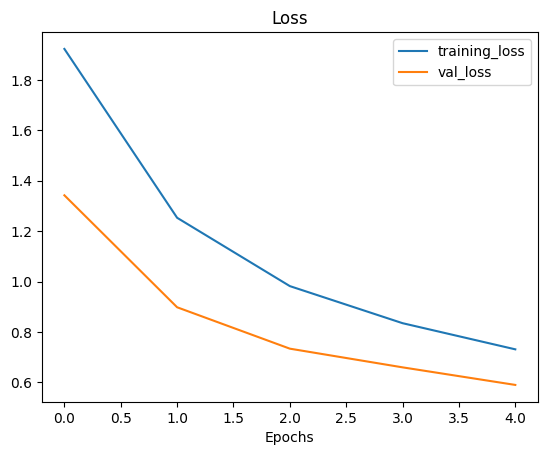

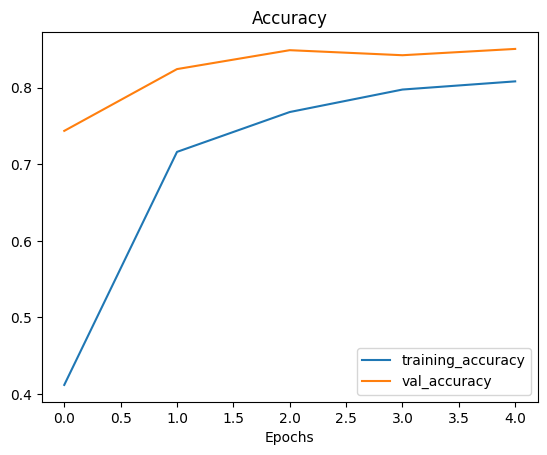

In [168]:
plot_loss_curves(history=history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [169]:
# Load in saved weights and evaluate model

model_2.load_weights(checkpoint_path)

In [170]:
# Evaluate model_2 with loaded weights

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6235 - accuracy: 0.8388


In [171]:
# Results from prev model_2 and current model with checkpoint weights are matched

model_2_results == loaded_weights_model_results

False

In [172]:
loaded_weights_model_results

[0.6234855651855469, 0.8388000130653381]

In [173]:
model_2_results

[0.6234856843948364, 0.8388000130653381]

In [174]:
# Checking to see if the loaded model results are very close to previous model_2 results

import numpy as np
np.isclose(np.array(model_2_results), np.array(loaded_weights_model_results))

array([ True,  True])

In [175]:
# Check the difference between 2 results

print( np.array(model_2_results) - np.array(loaded_weights_model_results) )

[1.1920929e-07 0.0000000e+00]


## 4. Model 3 - Base model with fine-tuning transfer learning on 10% of the training data with data data augmentation.

In [176]:
# Layers in loaded model

model_2.layers

In [177]:
# Are these layers trainable?

for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x796b3978c5e0> True
<keras.engine.sequential.Sequential object at 0x796b397b3af0> True
<keras.engine.functional.Functional object at 0x796b24c75d20> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x796b4449a050> True
<keras.layers.core.dense.Dense object at 0x796b2614f5b0> True


In [178]:
# EfficientNetB0 base model layers and trainable layers

for i, layer in enumerate (model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_17 False
1 rescaling_27 False
2 normalization_16 False
3 rescaling_28 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [179]:
# How many trainable variables in our base model?

print(len(model_2.layers[2].trainable_variables))

0


In [180]:
# To fine-tune, starting by making the last 10 layers of the base_model.trainable = True
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tuning, typically the learning rate is lowered by 10X.
                metrics=["accuracy"])

In [181]:
for i, layer in enumerate (model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_17 False
1 rescaling_27 False
2 normalization_16 False
3 rescaling_28 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [182]:
print(len(model_2.trainable_variables))

12


In [183]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_steps + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2_fine_tune = model_2.fit(train_data_10_percent,
                                  epochs=fine_tune_epochs,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=(0.25 * len(test_data)),
                                  initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230824-042716
Epoch 5/10
24/24 [==============================] - 20s 411ms/step - loss: 0.6133 - accuracy: 0.8093 - val_loss: 0.4679 - val_accuracy: 0.8469
Epoch 6/10
24/24 [==============================] - 9s 365ms/step - loss: 0.5203 - accuracy: 0.8493 - val_loss: 0.4281 - val_accuracy: 0.8562
Epoch 7/10
24/24 [==============================] - 9s 345ms/step - loss: 0.4446 - accuracy: 0.8667 - val_loss: 0.4138 - val_accuracy: 0.8594
Epoch 8/10
24/24 [==============================] - 8s 302ms/step - loss: 0.4065 - accuracy: 0.8693 - val_loss: 0.4007 - val_accuracy: 0.8703
Epoch 9/10
24/24 [==============================] - 9s 352ms/step - loss: 0.3621 - accuracy: 0.8933 - val_loss: 0.4103 - val_accuracy: 0.8594
Epoch 10/10
24/24 [==============================] - 11s 429ms/step - loss: 0.3514 - accuracy: 0.8933 - val_loss: 0.4322 - val_accuracy: 0.8500


In [184]:
# Evaluate the fine-tuned model (model_3 is actually the model_2 which has been fine-tuned for another 5 epochs)
results_model_2_fine_tuned = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4464 - accuracy: 0.8572


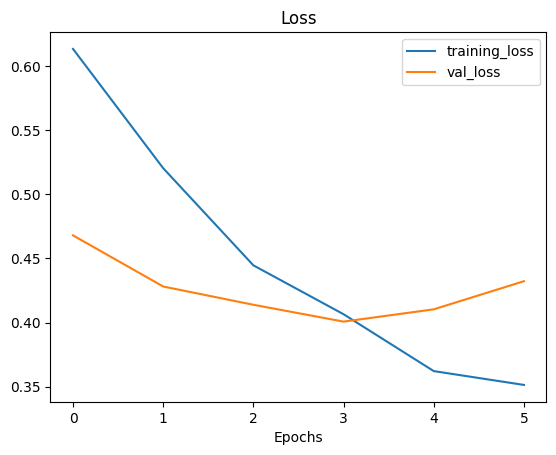

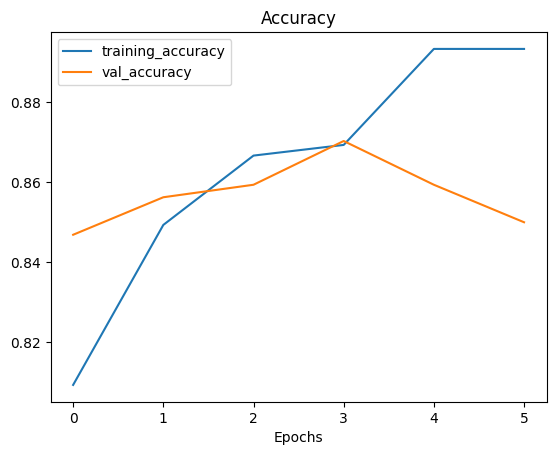

In [185]:
# Plot loss curves for the model_3 (fine tuned model_2)
plot_loss_curves(history=history_2_fine_tune)

### Plotting the History Comparison Model Curve

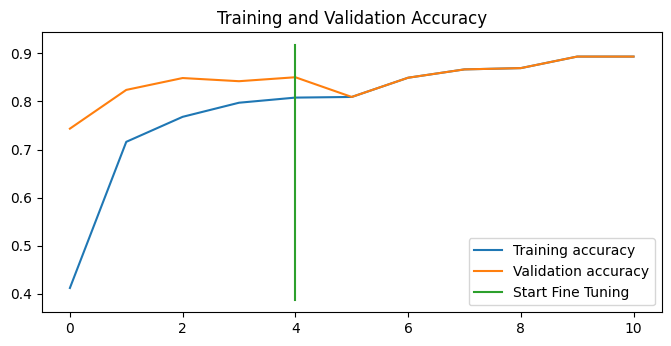

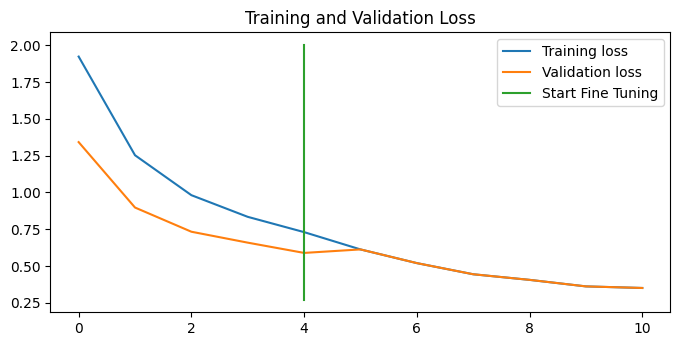

In [213]:
compare_history(original_history=history_2,
                new_history=history_2_fine_tune,
                initial_steps=5)

## 5. Model 4 - Using model 3 but with 100% of the training data.

In [187]:
# Download and unzip 10 classes of Food101 data with all images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-08-24 04:28:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  22.6MB/s    in 24s     

2023-08-24 04:29:06 (21.0 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [188]:
# Training and Test Dirs

train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [189]:
# Number of images being used
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 

In [190]:
# Setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To Train a fine-tuning model: Model_4, we need to revert model_2 back to its feature extraction weights.

In [191]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4464 - accuracy: 0.8572


[0.4463549256324768, 0.857200026512146]

In [194]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [195]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [196]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 73ms/step - loss: 0.6235 - accuracy: 0.8388


[0.6234856843948364, 0.8388000130653381]

In [200]:
# Check the layers that are tunable in the model

for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [198]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [199]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_18 False
1 rescaling_29 False
2 normalization_17 False
3 rescaling_30 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [207]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [205]:
# Recompile the model

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           metrics=["accuracy"])

In [206]:
# Fit the model

fine_tune_epochs = initial_steps + 5

history_full_data = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=(0.25*len(test_data)),
                                           initial_epoch=history_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_data")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_data/20230824-045125
Epoch 5/10
235/235 [==============================] - 64s 230ms/step - loss: 0.6462 - accuracy: 0.7920 - val_loss: 0.3708 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 55s 233ms/step - loss: 0.5249 - accuracy: 0.8296 - val_loss: 0.3429 - val_accuracy: 0.8938
Epoch 7/10
235/235 [==============================] - 47s 197ms/step - loss: 0.4701 - accuracy: 0.8459 - val_loss: 0.3582 - val_accuracy: 0.8797
Epoch 8/10
235/235 [==============================] - 47s 196ms/step - loss: 0.4263 - accuracy: 0.8639 - val_loss: 0.3596 - val_accuracy: 0.8813
Epoch 9/10
235/235 [==============================] - 42s 175ms/step - loss: 0.3906 - accuracy: 0.8775 - val_loss: 0.2828 - val_accuracy: 0.9047
Epoch 10/10
235/235 [==============================] - 43s 181ms/step - loss: 0.3607 - accuracy: 0.8841 - val_loss: 0.3050 - val_accuracy: 0.9062


In [208]:
# Evaluate on all test data
result_all_data = model_2.evaluate(test_data)

79/79 [==============================] - 8s 89ms/step - loss: 0.2787 - accuracy: 0.9140


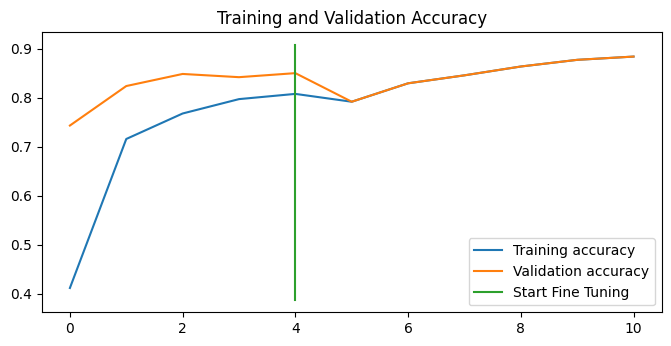

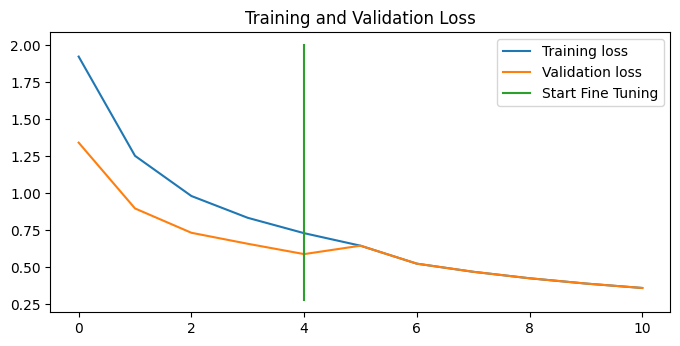

In [212]:
# Compare history

compare_history(original_history=history_2,
                new_history=history_full_data,
                initial_steps=5)

## View experiments on Tensorboard

In [215]:
# View tensorboard logs of transfer learning modelling experiments
# Upload tensorboard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food 101 classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2023-08-24 05:14:58.085889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VMX-GDC-TRV



New experiment created. View your TensorBoard at: https://tensorboard.dev/